In [91]:
__updated__ = '2021-12-24 00:55:52'
from Calculator import Calculator as Calc
from PlotTools import plt, plotKBar, transforDate #createPlot
from utils import (
    pd, np, getSchema, getDateBeforeTrade, 
    saveRecommand, timedelta, GetException,
    sendResultTable, VolumeFilter, PriceFilter,
    changedType, datetime
)
from copy import deepcopy
import matplotlib.dates as mpl_dates

In [20]:
def getData(td:datetime=datetime.today(), ticker:str=""):
    pre_3y = td + timedelta(-365*1)
    temp_df = pd.DataFrame(list(table.find({'Ticker':{'$eq':ticker},'Date':{'$gte':pre_3y.strftime('%Y-%m-%d'), '$lte':td.strftime('%Y-%m-%d')}}))).set_index('Date')
    return temp_df

In [4]:
#method 1: fractal candlestick pattern
# determine bullish fractal 
def is_support(df,i):  
    cond1 = df['Low'][i] < df['Low'][i-1]   
    cond2 = df['Low'][i] < df['Low'][i+1]   
    cond3 = df['Low'][i+1] < df['Low'][i+2]   
    cond4 = df['Low'][i-1] < df['Low'][i-2]  
    return (cond1 and cond2 and cond3 and cond4) 

# determine bearish fractal
def is_resistance(df,i):  
    cond1 = df['High'][i] > df['High'][i-1]   
    cond2 = df['High'][i] > df['High'][i+1]   
    cond3 = df['High'][i+1] > df['High'][i+2]   
    cond4 = df['High'][i-1] > df['High'][i-2]  
    return (cond1 and cond2 and cond3 and cond4)

# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
    ave =  np.mean(df['High'] - df['Low'])    
    return np.sum([abs(value-level)<ave for _,level in levels])==0


In [108]:
ticker = "2303"

df = getData(ticker=ticker)

In [104]:
def calculateLevels(df):
    # a list to store resistance and support levels
    levels = []
    for i in range(2, df.shape[0] - 2):  
        if is_support(df, i):    
            low = df['Low'][i]
            if is_far_from_level(low, levels, df):
                levels.append((i, low))
        elif is_resistance(df, i):
            high = df['High'][i]
            if is_far_from_level(high, levels, df):
                levels.append((i, high))
    return levels

def calculatePivots(df):
    pivots = []
    max_list = []
    min_list = []
    for i in range(5, len(df)-5):
        # taking a window of 9 candles
        high_range = df['High'][i-5:i+4]
        current_max = high_range.max()

        # if we find a new maximum value, empty the max_list 
        if current_max not in max_list:
            max_list = []
        max_list.append(current_max)

        # if the maximum value remains the same after shifting 5 times
        if len(max_list)==5 and is_far_from_level(current_max,pivots,df):
            pivots.append((high_range.idxmax(), current_max))

        low_range = df['Low'][i-5:i+5]
        current_min = low_range.min()
        if current_min not in min_list:
            min_list = []
        min_list.append(current_min)
        if len(min_list)==5 and is_far_from_level(current_min,pivots,df):
            pivots.append((low_range.idxmin(), current_min))
    return pivots

In [105]:
# for visualization
def plot_all(levels, df, ticker, expand_text=""):    
    df = deepcopy(df)
    fig, ax = plt.subplots(figsize=(16, 9))
    plotKBar(ax, df)#.set_index("Date"))
    df.DateStr = df.Date
    df.Date = df.Date.apply(transforDate)
    for i in range(len(levels)):
        next_level = None
        level = levels[i]
        try:
            next_level = levels[i+1]
        except:
            pass
        xmax = df['Date'].max()
        if next_level:
            if str(next_level[0]).isnumeric():
                xmax = df['Date'][next_level[0]]
            else:
                xmax = df[df.DateStr == next_level[0]].Date
        if str(level[0]).isnumeric():
            xmin = df['Date'][level[0]]
        else:
            xmin = df[df.DateStr == level[0]].Date
        plt.hlines(level[1], xmin = xmin, xmax = xmax, colors='blue', linestyle='--')
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format) 
    plt.title(f"Support and resistance ({expand_text}) of {ticker} in the past one year.")
    fig.show()

No handles with labels found to put in legend.
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


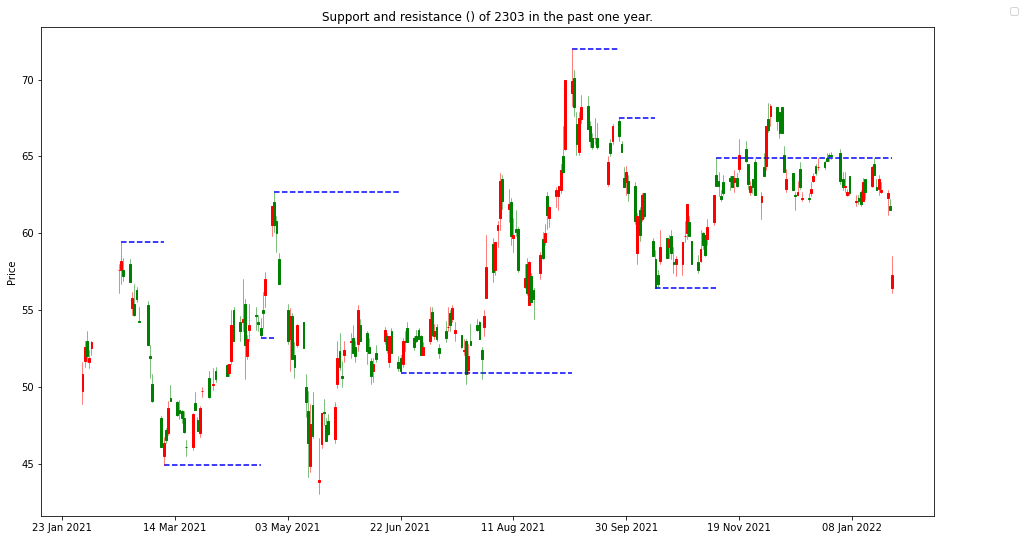

In [109]:
levels = calculateLevels(df)
plot_all(levels, df.reset_index(), ticker)

No handles with labels found to put in legend.
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
c:\users\kevin\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


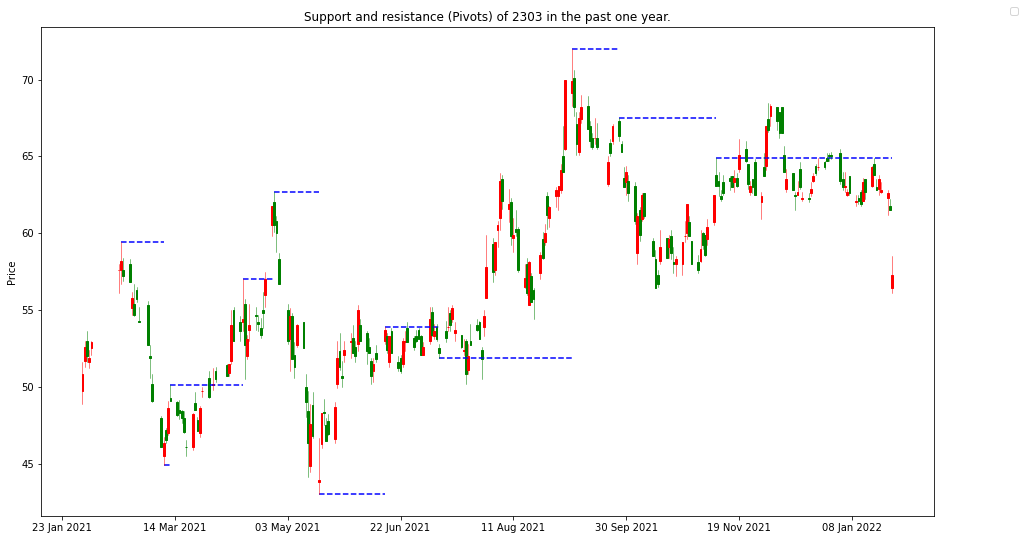

In [110]:
pivots = calculatePivots(df)
plot_all(pivots, df.reset_index(), ticker, "Pivots")